In [9]:
#add project directory to python path
import sys
sys.path.append("..")
from default import PROJECT_DIRECTORY, DATA_DIRECTORY
#import standard packages
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division
%matplotlib inline

#Rank Order SHAM Models

In this notebook I examine the basic properties of the rank order SHAM models in this paper.

In [2]:
from halotools import sim_manager

#load halo catalogue
simname = 'bolshoi_250'
halocat = sim_manager.CachedHaloCatalog(simname = simname, redshift=0.0, dz_tol = 0.001,
                                        version_name='custom', halo_finder='Rockstar')

#print out column names of halo catalogue
print(halocat.halo_table.dtype.names)

('halo_upid', 'halo_first_acc_mvir', 'halo_acc_scale', 'halo_rvir', 'halo_vpeak', 'halo_macc', 'halo_first_acc_scale', 'halo_mpeak', 'halo_half_mass_scale', 'halo_mvir', 'halo_T/|U|', 'halo_vmax_at_mpeak', 'halo_pid', 'halo_y', 'halo_x', 'halo_z', 'halo_m200b', 'halo_m200c', 'halo_first_acc_vmax', 'halo_mpeak_scale', 'halo_vmax', 'halo_vacc', 'halo_id', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rs', 'halo_nfw_conc', 'halo_hostid', 'halo_mvir_host_halo')


In [3]:
#define cosmology used in the simulation
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.27) #Bolshoi cosmology
print(cosmo)

FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.27, Tcmb0=2.725 K, Neff=3.04, m_nu=[ 0.  0.  0.] eV, Ob0=None)


##Build SHAM Models

In [11]:
from halotools.empirical_models import SubhaloModelFactory

#define stellar mass threshold for each mock
def galaxy_selection_func(table):
    mask = (table['stellar_mass'] >= 10**9.0) & (table['stellar_mass'] < np.inf)
    return mask

##Rank Order AM on Mpeak (model #1)

In [112]:
from SHAM_model_components import RankSmHm

#build model
prim_haloprop_key = 'halo_mpeak'
mstar_model = RankSmHm(prim_haloprop_key = prim_haloprop_key, Lbox=halocat.Lbox[0], redshift=0.0)
composite_model_1 = SubhaloModelFactory(stellar_mass = mstar_model, 
                                        galaxy_selection_func = galaxy_selection_func)

composite_model_1.param_dict['scatter'] = 0.0

#populate simulation
composite_model_1.populate_mock(halocat = halocat)
mock_1 = composite_model_1.mock.galaxy_table
print(mock_1.dtype.names)

('halo_upid', 'halo_hostid', 'halo_mpeak', 'halo_x', 'halo_y', 'halo_id', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rvir', 'halo_mvir', 'halo_mvir_host_halo', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'galid', 'stellar_mass')


###Fit SMHM Relation

In [113]:
#define functional form of the SMHM relation

def broken_powerlaw_model(logx, y0=10.35, x0=11.8, alpha=0.5, beta=0.65, s=1.0):
    """
    smooth transitioning broken powerlaw model
    """
    y0 = 10.0**y0
    x0 = 10.0**x0
    logx = np.atleast_1d(logx)
    x = 10.0**logx
    return np.log10((2.0*y0/x0)*x*((x/x0)**(-1.0*alpha) + s*(x/x0)**(beta))**(-1))

In [6]:
from scipy.stats import linregress

def empirical_SMHM(mstar, mhalo, bins, Nboot=25):
    """
    measure the log mean stellar mass and scatter as a function of halo mass
    """

    x = np.log10(mhalo)
    y = np.log10(mstar)

    bin_centers = (bins[:-1]+bins[1:])/2.0 #log bins
    
    std_y = np.zeros((Nboot, len(bins)-1))
    mean_y = np.zeros((Nboot, len(bins)-1))
    for i in range(0,Nboot):
        boot_inds = np.random.randint(0, len(x), len(x))
        
        xx = x[boot_inds]
        yy = y[boot_inds]
        
        inds = np.digitize(xx, bins=bins)
    
        for j in range(1,len(bins)):
            mask = (inds==j)
            m, b, r, p, e = linregress(xx[mask],yy[mask])
            yyy = yy[mask] - (m*xx[mask] + b) 
            std_y[i,j-1] = np.std(yyy)
            mean_y[i,j-1] = (m*bin_centers[j-1] + b) 
    
    mean_y_err= np.std(mean_y, axis=0)
    mean_y = np.mean(mean_y, axis=0)
    std_y_err = np.std(std_y, axis=0)
    std_y = np.mean(std_y, axis=0)
    
    return bin_centers, mean_y, std_y, mean_y_err, std_y_err

In [116]:
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit

min_m = 11.2
bins = np.arange(min_m,14.5,0.1) #log bins

result = empirical_SMHM(mock_1['stellar_mass'], mock_1['halo_mpeak'], bins, Nboot=10)
bin_centers, mean_y, std_y,  mean_y_err, std_y_err = result

#get linear errors
err_plus = 10**(mean_y + mean_y_err)-10**(mean_y)
err_minus = 10**(mean_y) - 10**(mean_y - mean_y_err)
lin_err = np.vstack((err_minus, err_plus))

#fit model
popt, cov = curve_fit(broken_powerlaw_model, bin_centers, mean_y,# sigma=mean_y_err,
                      p0=[10.35, 11.8, 0.5, 0.65], bounds=([9.0, 10.0, 0.0, 0.0],[12.0, 13.0, 2.0, 2.0]))
param_err = np.sqrt(cov.diagonal())
print('y0 = {0} +- {1}'.format(popt[0],param_err[0]))
print('x0 = {0} +- {1}'.format(popt[1],param_err[1]))
print('alpha = {0} +- {1}'.format(popt[2],param_err[2]))
print('beta = {0} +- {1}'.format(popt[3],param_err[3]))
print(' ')

#use parameters to set model
smhm_model = lambda x: 10**broken_powerlaw_model(np.log10(x), *popt)

y0 = 9.95684145213 +- 0.0137631180179
x0 = 11.6790474 +- 0.0143821285884
alpha = 0.968819977655 +- 0.0434704218997
beta = 0.617142219119 +- 0.00442295503177
 


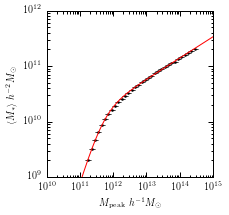

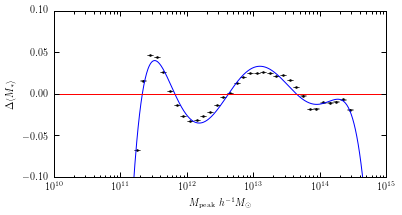

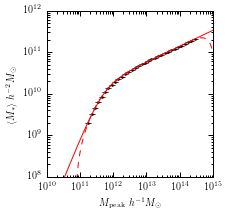

In [118]:
m_sample = np.logspace(9,16,1000)

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(10**bin_centers, 10**mean_y, yerr=lin_err, fmt='o', ms=2, color='black')
plt.plot(m_sample, smhm_model(m_sample), '-', color='red')
plt.ylim([10**9.0,10**12.0])
plt.xlim([10**10,10**15])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$M_{\rm peak}~h^{-1}M_{\odot}$')
plt.ylabel(r'$\langle M_{*}\rangle~h^{-2}M_{\odot}$')
plt.show()

x = 10**bin_centers
y = (10**mean_y-smhm_model(10**bin_centers))/smhm_model(10**bin_centers)
y_err = lin_err/smhm_model(10**bin_centers)

result = np.polyfit(np.log10(x), y, deg=6)#, w=1.0/y_err)
p = np.poly1d(result)

fig = plt.figure(figsize=(6.6,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(x, y, yerr=y_err, fmt='o', ms=2, color='black')
plt.plot(m_sample, p(np.log10(m_sample)))
plt.plot(m_sample, (smhm_model(m_sample)-smhm_model(m_sample))/smhm_model(m_sample), '-', color='red')
plt.ylim([-0.1,0.1])
plt.xlim([10**10,10**15])
plt.xscale('log')
plt.xlabel(r'$M_{\rm peak}~h^{-1}M_{\odot}$')
plt.ylabel(r'$\Delta\langle M_{*}\rangle$')
plt.show()

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(10**bin_centers, 10**mean_y, yerr=lin_err, fmt='o', ms=2, color='black')
plt.plot(m_sample, smhm_model(m_sample), '-', color='red')
plt.plot(m_sample, smhm_model(m_sample)+p(np.log10(m_sample))*smhm_model(m_sample), '--', color='red')
plt.ylim([10**8.0,10**12.0])
plt.xlim([10**10,10**15])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$M_{\rm peak}~h^{-1}M_{\odot}$')
plt.ylabel(r'$\langle M_{*}\rangle~h^{-2}M_{\odot}$')
plt.show()

##Rank Order AM on Vpeak (model #2)

In [12]:
from SHAM_model_components import RankSmHm

#build model
prim_haloprop_key = 'halo_vpeak'
mstar_model = RankSmHm(prim_haloprop_key = prim_haloprop_key, Lbox=halocat.Lbox[0], redshift=0.0)
composite_model_2 = SubhaloModelFactory(stellar_mass = mstar_model,
                                        galaxy_selection_func = galaxy_selection_func)

composite_model_2.param_dict['scatter'] = 0.0

#populate simulation
composite_model_2.populate_mock(halocat = halocat)
mock_2 = composite_model_2.mock.galaxy_table
print(mock_2.dtype.names)

print("number of galaxies in mock: ", len(mock_2))
f_sat = float(np.sum(mock_2['halo_upid']!=-1))/len(mock_2)
print("satellite fraction: ", f_sat)

('halo_upid', 'halo_hostid', 'halo_x', 'halo_y', 'halo_id', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rvir', 'halo_vpeak', 'halo_mvir', 'halo_mvir_host_halo', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'galid', 'stellar_mass')
number of galaxies in mock:  483749
satellite fraction:  0.287585090615


###Fit SMVP Relation

In [4]:
#define functional form of the SMHM relation

def broken_powerlaw_model(logx, y0=10.0, x0=2.2, alpha=-4.5, beta=-0.2, s=1.0):
    """
    smooth transitioning broken powerlaw model
    """
    y0 = 10.0**y0
    x0 = 10.0**x0
    logx = np.atleast_1d(logx)
    x = 10.0**logx
    return np.log10((2.0*y0/x0)*x*((x/x0)**(alpha) + s*(x/x0)**(beta))**(-1))

In [17]:
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit

min_v = 2.0
bins = np.arange(min_v,3.1,0.025) #log bins

result = empirical_SMHM(mock_2['stellar_mass'], mock_2['halo_vpeak'], bins, Nboot=10)
bin_centers, mean_y, std_y,  mean_y_err, std_y_err = result

#get linear errors
err_plus = 10**(mean_y + mean_y_err)-10**(mean_y)
err_minus = 10**(mean_y) - 10**(mean_y - mean_y_err)
lin_err = np.vstack((err_minus, err_plus))

#fit model

popt, cov = curve_fit(broken_powerlaw_model, bin_centers, mean_y,# sigma=mean_y_err,
                      p0=[10.0, 2.2, -5, 0.2], bounds=([9.0,0.0,-10.0,-1.0],[10.0,3.0,0.0,2]))
param_err = np.sqrt(cov.diagonal())
print('y0 = {0} +- {1}'.format(popt[0],param_err[0]))
print('x0 = {0} +- {1}'.format(popt[1],param_err[1]))
print('alpha = {0} +- {1}'.format(popt[2],param_err[2]))
print('beta = {0} +- {1}'.format(popt[3],param_err[3]))
print(' ')

#use parameters to set model
smvp_model = lambda x: 10**broken_powerlaw_model(np.log10(x), *popt)

y0 = 9.94691445239 +- 0.0153438045223
x0 = 2.1810951354 +- 0.00474964734869
alpha = -5.95254734483 +- 0.14951554599
beta = -0.249567751716 +- 0.0167145909488
 


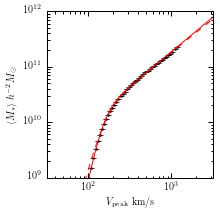

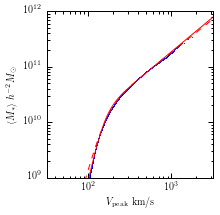

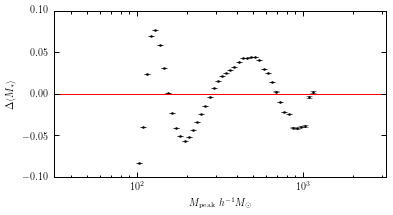

In [18]:
v_sample = np.logspace(1.0,3.5,1000)

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(10**bin_centers, 10**mean_y, yerr=lin_err, fmt='o', ms=2, color='black')
plt.plot(v_sample, smvp_model(v_sample), '-', color='red')
plt.plot(v_sample, 10**broken_powerlaw_model(np.log10(v_sample)), '--', color='red')
plt.ylim([10**9.0,10**12.0])
plt.xlim([10**1.5,10**3.5])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$V_{\rm peak}~{\rm km/s}$')
plt.ylabel(r'$\langle M_{*}\rangle~h^{-2}M_{\odot}$')
plt.show()

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.plot(mock_2['halo_vpeak'],mock_2['stellar_mass'],'.', ms=1)
plt.plot(v_sample, smvp_model(v_sample), '-', color='red')
plt.plot(v_sample, 10**broken_powerlaw_model(np.log10(v_sample)), '--', color='red')
plt.ylim([10**9.0,10**12.0])
plt.xlim([10**1.5,10**3.5])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$V_{\rm peak}~{\rm km/s}$')
plt.ylabel(r'$\langle M_{*}\rangle~h^{-2}M_{\odot}$')
plt.show()

fig = plt.figure(figsize=(6.6,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(10**bin_centers, (10**mean_y-smvp_model(10**bin_centers))/smvp_model(10**bin_centers), yerr=lin_err/smvp_model(10**bin_centers), fmt='o', ms=2, color='black')
plt.plot(v_sample, (smvp_model(v_sample)-smvp_model(v_sample))/smvp_model(v_sample), '-', color='red')
plt.ylim([-0.1,0.1])
plt.xlim([10**1.5,10**3.5])
plt.xscale('log')
plt.xlabel(r'$M_{\rm peak}~h^{-1}M_{\odot}$')
plt.ylabel(r'$\Delta \langle M_{*}\rangle$')
plt.show()

##Fit dependence of RV on $\sigma_{\log(M_*)}$

In [15]:
composite_model_2.param_dict['scatter'] = 0.0
composite_model_2.populate_mock(halocat = halocat)
mock_2_00 = composite_model_2.mock.galaxy_table

composite_model_2.param_dict['scatter'] = 0.05
composite_model_2.populate_mock(halocat = halocat)
mock_2_05 = composite_model_2.mock.galaxy_table

composite_model_2.param_dict['scatter'] = 0.1
composite_model_2.populate_mock(halocat = halocat)
mock_2_10 = composite_model_2.mock.galaxy_table

composite_model_2.param_dict['scatter'] = 0.15
composite_model_2.populate_mock(halocat = halocat)
mock_2_15 = composite_model_2.mock.galaxy_table

composite_model_2.param_dict['scatter'] = 0.20
composite_model_2.populate_mock(halocat = halocat)
mock_2_20 = composite_model_2.mock.galaxy_table

composite_model_2.param_dict['scatter'] = 0.25
composite_model_2.populate_mock(halocat = halocat)
mock_2_25 = composite_model_2.mock.galaxy_table

composite_model_2.param_dict['scatter'] = 0.30
composite_model_2.populate_mock(halocat = halocat)
mock_2_30 = composite_model_2.mock.galaxy_table

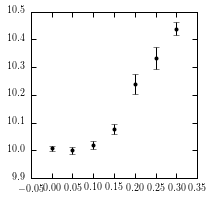

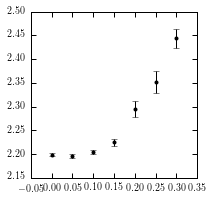

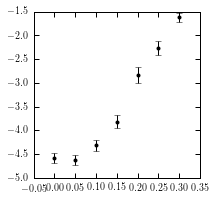

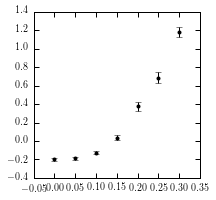

In [345]:
def fit_smvp_model(mock, verbose=False):
    
    x = np.log10(np.array(mock['halo_vpeak']))
    y = np.log10(np.array(mock['stellar_mass']))
    
    mask = (y<9.6)
    min_v = 1.5*np.std(x[mask]) + np.median(x[mask])
    bins = np.arange(min_v,3.1,0.025) #log bins

    result = empirical_SMHM(mock['stellar_mass'], mock['halo_vpeak'], bins, Nboot=10)
    bin_centers, mean_y, std_y,  mean_y_err, std_y_err = result

    #get linear errors
    err_plus = 10**(mean_y + mean_y_err)-10**(mean_y)
    err_minus = 10**(mean_y) - 10**(mean_y - mean_y_err)
    lin_err = np.vstack((err_minus, err_plus))

    #fit model
    popt, cov = curve_fit(broken_powerlaw_model, median_x, mean_y, sigma=mean_y_err,
                          p0=[10.0, 2.2, -5, 0.2], bounds=([9.0,0.0,-10.0,-1.0],[11.0,3.0,0.0,2]))
    param_err = np.sqrt(cov.diagonal())
    if verbose:
        print('y0 = {0} +- {1}'.format(popt[0],param_err[0]))
        print('x0 = {0} +- {1}'.format(popt[1],param_err[1]))
        print('alpha = {0} +- {1}'.format(popt[2],param_err[2]))
        print('beta = {0} +- {1}'.format(popt[3],param_err[3]))
        print(' ')
    
    return popt, param_err

#get model parameters for each mock
popt_00, err_00 = fit_smvp_model(mock_2_00)
popt_05, err_05 = fit_smvp_model(mock_2_05)
popt_10, err_10 = fit_smvp_model(mock_2_10)
popt_15, err_15 = fit_smvp_model(mock_2_15)
popt_20, err_20 = fit_smvp_model(mock_2_20)
popt_25, err_25 = fit_smvp_model(mock_2_25)
popt_30, err_30 = fit_smvp_model(mock_2_30)

sigmas = np.array([0,0.05,0.1,0.15,0.2,0.25,0.3])
y0s = np.array([popt_00[0],popt_05[0],popt_10[0],popt_15[0],popt_20[0],popt_25[0],popt_30[0]])
x0s = np.array([popt_00[1],popt_05[1],popt_10[1],popt_15[1],popt_20[1],popt_25[1],popt_30[1]])
alphas = np.array([popt_00[2],popt_05[2],popt_10[2],popt_15[2],popt_20[2],popt_25[2],popt_30[2]])
betas = np.array([popt_00[3],popt_05[3],popt_10[3],popt_15[3],popt_20[3],popt_25[3],popt_30[3]])

y0s_err = np.array([err_00[0],err_05[0],err_10[0],err_15[0],err_20[0],err_25[0],err_30[0]])
x0s_err = np.array([err_00[1],err_05[1],err_10[1],err_15[1],err_20[1],err_25[1],err_30[1]])
alphas_err  = np.array([err_00[2],err_05[2],err_10[2],err_15[2],err_20[2],err_25[2],err_30[2]])
betas_err  = np.array([err_00[3],err_05[3],err_10[3],err_15[3],err_20[3],err_25[3],err_30[3]])

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(sigmas, y0s, yerr=y0s_err, fmt='o', mec='none', color='black', ms=4)
plt.xlim([-0.05,0.35])
plt.show()

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(sigmas, x0s, yerr=x0s_err, fmt='o', mec='none', color='black', ms=4)
plt.xlim([-0.05,0.35])
plt.show()

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(sigmas, alphas, yerr=alphas_err, fmt='o', mec='none', color='black', ms=4)
plt.xlim([-0.05,0.35])
plt.show()

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(sigmas, betas, yerr=betas_err, fmt='o', mec='none', color='black', ms=4)
plt.xlim([-0.05,0.35])
plt.show()

x0 = 0.476266680208 +- 0.0408018733164
alpha = 2.1184395692 +- 0.357199582502
b = 8.99664839272 +- 0.012098714121
 


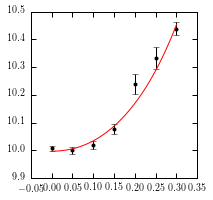

In [347]:
def exp_model(x, x0=0.5, alpha=1.5, b=-1.2, a=1.0):
    return a*np.exp((x/x0)**alpha) + b

popt, cov = curve_fit(exp_model, sigmas, y0s, sigma=y0s_err, p0=[0.5,1.5,10.0])
param_err = np.sqrt(cov.diagonal())
print('x0 = {0} +- {1}'.format(popt[0],param_err[0]))
print('alpha = {0} +- {1}'.format(popt[1],param_err[1]))
print('b = {0} +- {1}'.format(popt[2],param_err[2]))
#print('a = {0} +- {1}'.format(popt[3],param_err[3]))
print(' ')

y0_model = lambda x: exp_model(x, *popt)

x_sample = np.linspace(0,0.3,100)

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(sigmas, y0s, yerr=y0s_err, fmt='o', mec='none', color='black', ms=4)
plt.plot(x_sample, y0_model(x_sample), '-', color='red')
plt.xlim([-0.05,0.35])
plt.show()

x0 = 0.504665468139 +- 0.0297877386834
alpha = 2.84627245914 +- 0.262326036949
b = 1.19657219325 +- 0.00234784583003
 


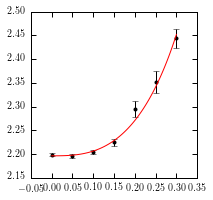

In [348]:
def exp_model(x, x0=0.5, alpha=1.5, b=-1.2, a=1.0):
    return a*np.exp((x/x0)**alpha) + b

popt, cov = curve_fit(exp_model, sigmas, x0s, sigma=x0s_err, p0=[0.5,1.5,2.0])
param_err = np.sqrt(cov.diagonal())
print('x0 = {0} +- {1}'.format(popt[0],param_err[0]))
print('alpha = {0} +- {1}'.format(popt[1],param_err[1]))
print('b = {0} +- {1}'.format(popt[2],param_err[2]))
#print('a = {0} +- {1}'.format(popt[3],param_err[3]))
print(' ')

x0_model = lambda x: exp_model(x, *popt)

x_sample = np.linspace(0,0.3,100)

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(sigmas, x0s, yerr=x0s_err, fmt='o', mec='none', color='black', ms=4)
plt.plot(x_sample, x0_model(x_sample), '-', color='red')
plt.xlim([-0.05,0.35])
plt.show()

x0 = 0.214526377611 +- 0.0183303683477
alpha = 1.06367841191 +- 0.218974010869
b = -5.71993003562 +- 0.156168072496
 


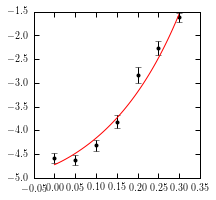

In [349]:
def exp_model(x, x0=0.5, alpha=1.5, b=-1.2, a=1.0):
    return a*np.exp((x/x0)**alpha) + b

popt, cov = curve_fit(exp_model, sigmas, alphas, sigma=alphas_err, p0=[0.5,1.5,-4.5])
param_err = np.sqrt(cov.diagonal())
print('x0 = {0} +- {1}'.format(popt[0],param_err[0]))
print('alpha = {0} +- {1}'.format(popt[1],param_err[1]))
print('b = {0} +- {1}'.format(popt[2],param_err[2]))
#print('a = {0} +- {1}'.format(popt[3],param_err[3]))
print(' ')

alpha_model = lambda x: exp_model(x, *popt)

x_sample = np.linspace(0,0.3,100)

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(sigmas, alphas, yerr=alphas_err, fmt='o', mec='none', color='black', ms=4)
plt.plot(x_sample, alpha_model(x_sample), '-', color='red')
plt.xlim([-0.05,0.35])
plt.show()

x0 = 0.318402892969 +- 0.00629313370839
alpha = 1.99789027811 +- 0.156690530056
b = -1.20897149458 +- 0.0141943093655
 


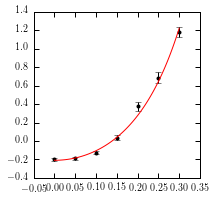

In [346]:
def exp_model(x, x0=0.5, alpha=1.5, b=-1.2, a=1.0):
    return a*np.exp((x/x0)**alpha) + b

popt, cov = curve_fit(exp_model, sigmas, betas, sigma=betas_err, p0=[0.5,1.5,-1.2])
param_err = np.sqrt(cov.diagonal())
print('x0 = {0} +- {1}'.format(popt[0],param_err[0]))
print('alpha = {0} +- {1}'.format(popt[1],param_err[1]))
print('b = {0} +- {1}'.format(popt[2],param_err[2]))
#print('a = {0} +- {1}'.format(popt[3],param_err[3]))
print(' ')

beta_model = lambda x: exp_model(x, *popt)

x_sample = np.linspace(0,0.3,100)

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(sigmas, betas, yerr=betas_err, fmt='o', mec='none', color='black', ms=4)
plt.plot(x_sample, beta_model(x_sample), '-', color='red')
plt.xlim([-0.05,0.35])
plt.show()

In [337]:
popt, cov = curve_fit(exp_model, sigmas, betas, sigma=betas_err, p0=[0.5,1.5,-1.2])
param_err = np.sqrt(cov.diagonal())
print('x0 = {0} +- {1}'.format(popt[0],param_err[0]))
print('alpha = {0} +- {1}'.format(popt[1],param_err[1]))
print('b = {0} +- {1}'.format(popt[2],param_err[2]))
#print('a = {0} +- {1}'.format(popt[3],param_err[3]))
print(' ')

x0 = 0.430318579252 +- 0.0130520320995
alpha = 1.91869795173 +- 0.0928067535698
b = -1.20814949614 +- 0.00435726383479
 


In [1]:
from SHAM_model_components import ParamSmHm

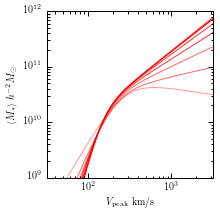

In [8]:
smvp_model = ParamSmHm()
v_sample = np.logspace(1.0,3.5,1000)

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.plot(v_sample, smvp_model.mean_stellar_mass(prim_haloprop=v_sample, scatter=0.0), '-', color='red', alpha=1.0)
plt.plot(v_sample, smvp_model.mean_stellar_mass(prim_haloprop=v_sample, scatter=0.05), '-', color='red', alpha=1.0)
plt.plot(v_sample, smvp_model.mean_stellar_mass(prim_haloprop=v_sample, scatter=0.1), '-', color='red', alpha=0.8)
plt.plot(v_sample, smvp_model.mean_stellar_mass(prim_haloprop=v_sample, scatter=0.15), '-', color='red', alpha=0.8)
plt.plot(v_sample, smvp_model.mean_stellar_mass(prim_haloprop=v_sample, scatter=0.2), '-', color='red', alpha=0.6)
plt.plot(v_sample, smvp_model.mean_stellar_mass(prim_haloprop=v_sample, scatter=0.25), '-', color='red', alpha=0.6)
plt.plot(v_sample, smvp_model.mean_stellar_mass(prim_haloprop=v_sample, scatter=0.3), '-', color='red', alpha=0.4)
plt.ylim([10**9.0,10**12.0])
plt.xlim([10**1.5,10**3.5])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$V_{\rm peak}~{\rm km/s}$')
plt.ylabel(r'$\langle M_{*}\rangle~h^{-2}M_{\odot}$')
plt.show()

##Fit dependence of RM on $\sigma_{\log(M_*)}$

In [ ]:
composite_model_1.param_dict['scatter'] = 0.0
composite_model_1.populate_mock(halocat = halocat)
mock_1_00 = composite_model_1.mock.galaxy_table

composite_model_1.param_dict['scatter'] = 0.05
composite_model_1.populate_mock(halocat = halocat)
mock_1_05 = composite_model_1.mock.galaxy_table

composite_model_1.param_dict['scatter'] = 0.1
composite_model_1.populate_mock(halocat = halocat)
mock_1_10 = composite_model_1.mock.galaxy_table

composite_model_1.param_dict['scatter'] = 0.15
composite_model_1.populate_mock(halocat = halocat)
mock_1_15 = composite_model_1.mock.galaxy_table

composite_model_1.param_dict['scatter'] = 0.20
composite_model_1.populate_mock(halocat = halocat)
mock_1_20 = composite_model_1.mock.galaxy_table

composite_model_1.param_dict['scatter'] = 0.25
composite_model_1.populate_mock(halocat = halocat)
mock_1_25 = composite_model_1.mock.galaxy_table

composite_model_1.param_dict['scatter'] = 0.30
composite_model_1.populate_mock(halocat = halocat)
mock_1_30 = composite_model_1.mock.galaxy_table